### FCNN

/tmp/ipykernel_1258390/1402469998.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['combined'] = df_all['PATGROUPFINAL_C'].astype(str) + df_all['METFORMIN_C'].astype(str)
/tmp/ipykernel_1258390/1402469998.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer 

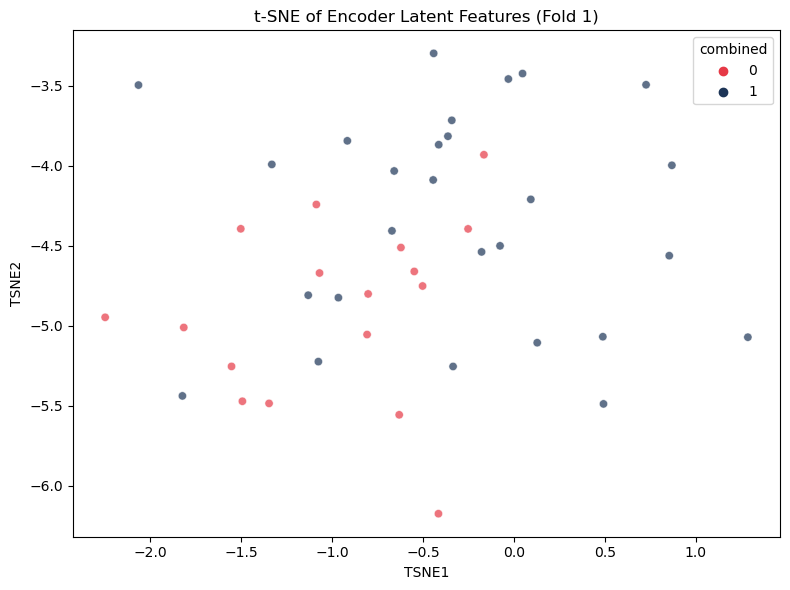

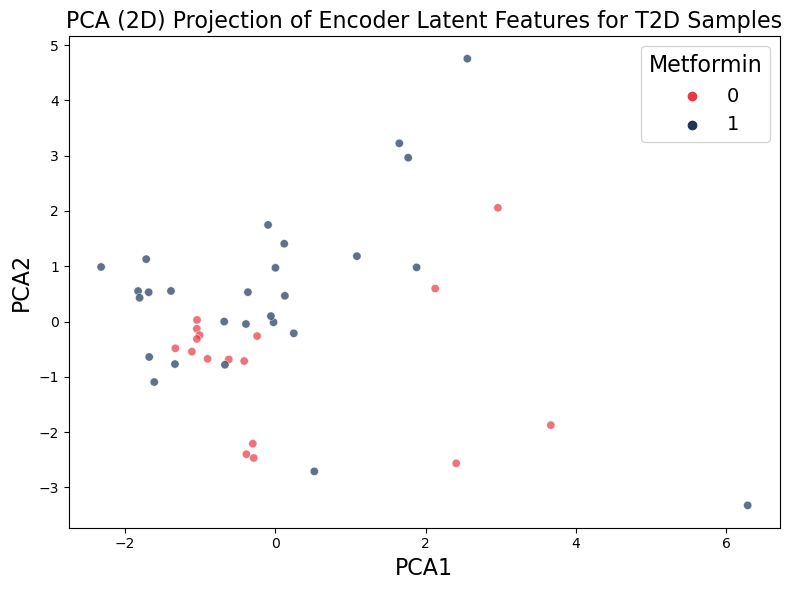

/home/mmonshiz/miniconda3/envs/confounder_free/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


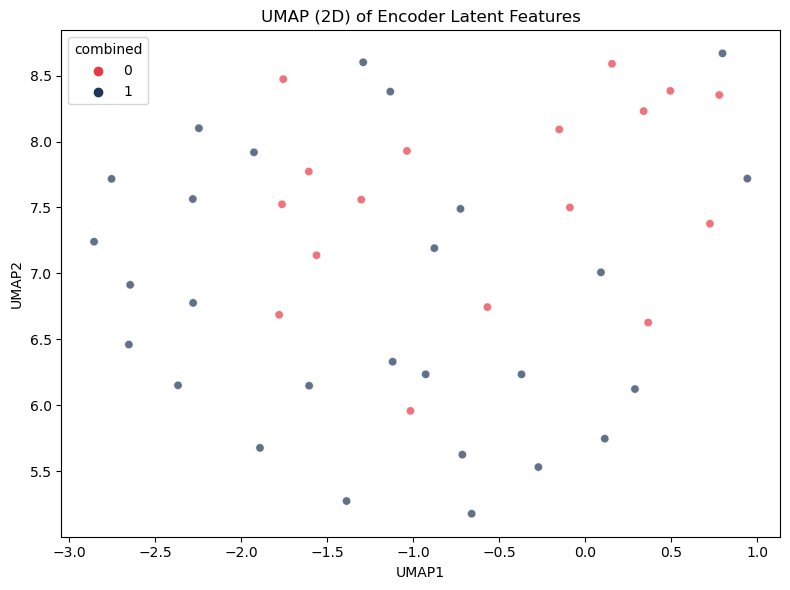

Silhouette Score: 0.06258658319711685
Davies-Bouldin Index: 2.829152576706181
Cluster Separation: 0.6220180761279586
Within-Cluster Variance: 4.982886574485085


In [5]:
# encoder_features_tsne.ipynb

import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

# For dimensionality reduction and visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# For PCA
from sklearn.decomposition import PCA
# For UMAP (make sure you have 'umap-learn' package installed: pip install umap-learn)
import umap.umap_ as umap


# -- Import your custom modules (same as in main.py) --
from FCNN_lib.data_utils import get_data
from FCNN_lib.models import GAN
from FCNN_lib.utils import create_stratified_dataloader

# ----------------------------
# 1. Load your data
# ----------------------------

# Adjust paths as needed
train_abundance_path = 'MetaCardis_data/new_train_T2D_abundance_with_taxon_ids.csv'
train_metadata_path  = 'MetaCardis_data/train_T2D_metadata.csv'

# If you want to do TSNE on test data instead, change accordingly
test_abundance_path  = 'MetaCardis_data/new_test_T2D_abundance_with_taxon_ids.csv'
test_metadata_path   = 'MetaCardis_data/test_T2D_metadata.csv'

# We'll load BOTH train and test sets, then optionally concatenate or pick one
df_train = get_data(train_abundance_path, train_metadata_path)
df_test  = get_data(test_abundance_path,  test_metadata_path)

# Let’s combine them if you want to do TSNE on the entire set. 
# Otherwise, you can pick just train or test
# df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all = df_test[df_test['PATGROUPFINAL_C']==1]

# ----------------------------
# 2. Create "combined" column
# ----------------------------
# combined = PATGROUPFINAL_C (0 or 1) + METFORMIN_C (0 or 1)
df_all['combined'] = df_all['PATGROUPFINAL_C'].astype(str) + df_all['METFORMIN_C'].astype(str)

# ----------------------------
# 3. Identify feature columns
# ----------------------------
# We do the same logic as in main.py to separate metadata from actual features
metadata_cols = pd.read_csv(train_metadata_path).columns.tolist()
metadata_cols += ['combined']
feature_columns = [
    col for col in df_all.columns if col not in metadata_cols and col != 'SampleID'
]

# Extract the feature matrix X and the combined column (for coloring)
X_all = df_all[feature_columns].values.astype(np.float32)
combined_labels = df_all['METFORMIN_C'].values  # Strings like "00", "01", "10", "11"

# Also store sample IDs if you want to track them
sample_ids = df_all['SampleID'].values

# ----------------------------
# 4. Define the same model structure used in main.py
#    and load each of the 5 fold models
# ----------------------------

# You need the same mask that was built in your main code for the MaskedLinear
# We'll replicate the process or load it if you saved it somewhere
# Suppose you saved the 'EdgeList.csv' and repeated the same steps:



relative_abundance_train = pd.read_csv(train_abundance_path, index_col=0)
species = relative_abundance_train.columns.values.tolist()

# Model hyperparams (must match your main.py)
latent_dim = 64
num_layers = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We’ll collect the encoder’s outputs from each fold in a list
all_latent_features_per_fold = []

# Loop over 5 folds
for fold in range(1, 6):
    # Rebuild the same model architecture
    model = GAN(371, 64, 1).to(device)
    # Load trained weights
    model_path = f"Results/FCNN_plots/trained_model{fold}.pth"
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}")
        continue

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # ----------------------------
    # 5. Get the encoder output for the entire data (df_all)
    # ----------------------------
    # Convert X_all to torch tensor, push to device
    X_tensor = torch.tensor(X_all, dtype=torch.float32).to(device)

    with torch.no_grad():
        encoded = model.encoder(X_tensor)
    # Move back to CPU numpy
    encoded_np = encoded.cpu().numpy()

    # Store the result for later TSNE or immediate TSNE
    all_latent_features_per_fold.append(encoded_np)

# Now you have a list of 5 arrays, each is n_samples x latent_dim
# Decide if you want to average them, or keep them separate.
# For demonstration, let's say we do TSNE on the *first fold only*,
# or you can concatenate them. Examples are below:

# Example A: TSNE on the first fold only
latent_fold1 = all_latent_features_per_fold[1]

# Example B (optional): Concatenate all folds and then do TSNE
# stacked_latent = np.concatenate(all_latent_features_per_fold, axis=0)
# But note that means you'd also replicate your labels for each fold, etc.

# ----------------------------
# 6. Perform TSNE
# ----------------------------
# Here we do TSNE on just 'latent_fold1' for demonstration
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(latent_fold1)

# ----------------------------
# 7. Visualize or Save
# ----------------------------
# Let’s create a DataFrame to store results
tsne_df = pd.DataFrame({
    'TSNE1': latent_2d[:, 0],
    'TSNE2': latent_2d[:, 1],
    'combined': combined_labels,
    'SampleID': sample_ids
})

# Save if you want
tsne_df.to_csv("fcnn_encoder_fold1_tsne.csv", index=False)

# Quick scatter plot by "combined"
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='combined',
    data=tsne_df,
    palette=custom_palette,  # or any palette you like
    alpha=0.7
)
plt.title("t-SNE of Encoder Latent Features (Fold 1)")
plt.legend(title='combined')
plt.tight_layout()
output_filename = "FCNN_tsne_encoder.png"
# plt.savefig(output_filename, dpi=300, format='png')
plt.show()

# -----------
# PCA
# -----------

custom_palette = {
    0: '#E63946',  # Red for class 0
    1: '#1D3557',  # Blue for class 1
}

pca = PCA(n_components=2, random_state=42)
pca_2d = pca.fit_transform(encoded_np)  # shape -> N x 2

# Create a small DataFrame to keep track of PCA coords + your label
pca_df = pd.DataFrame({
    'PCA1': pca_2d[:, 0],
    'PCA2': pca_2d[:, 1],
    'combined': combined_labels  # e.g. "00", "01", "10", "11"
})

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='combined', 
    data=pca_df, 
    palette=custom_palette, 
    alpha=0.7
)
plt.title("PCA (2D) Projection of Encoder Latent Features for T2D Samples", fontsize=16)
plt.xlabel("PCA1", fontsize=16)
plt.ylabel("PCA2", fontsize=16)
plt.legend(title='Metformin', fontsize=14, title_fontsize=16)
plt.tight_layout()
output_filename = "FCNN_PCA_encoder.pdf"
plt.savefig(output_filename, dpi=300, format='pdf')
plt.show()

# -----------
# U-map
# -----------

# UMAP can similarly reduce your N x latent_dim to N x 2.
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_2d = umap_reducer.fit_transform(encoded_np)  # shape -> N x 2

# Create DataFrame
umap_df = pd.DataFrame({
    'UMAP1': umap_2d[:, 0],
    'UMAP2': umap_2d[:, 1],
    'combined': combined_labels
})
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='UMAP1', y='UMAP2',
    hue='combined',
    data=umap_df,
    palette=custom_palette,
    alpha=0.7
)
plt.title("UMAP (2D) of Encoder Latent Features")
plt.legend(title='combined')
plt.tight_layout()
output_filename = "FCNN_UMAP_encoder.pdf"
# plt.savefig(output_filename, dpi=300, format='pdf')
plt.show()

from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist

# Assume latent_2d is your reduced data and combined_labels are your labels
silhouette = silhouette_score(pca_2d, combined_labels)
print(f"Silhouette Score: {silhouette}")

db_index = davies_bouldin_score(pca_2d, combined_labels)
print(f"Davies-Bouldin Index: {db_index}")

# Calculate cluster centers
clusters = np.unique(combined_labels)
centers = [pca_2d[combined_labels == c].mean(axis=0) for c in clusters]
# Compute mean distance between cluster centers
cluster_separation = np.mean(cdist(centers, centers))
print(f"Cluster Separation: {cluster_separation}")

# Compute within-cluster variance
within_variance = sum(
    np.sum((pca_2d[combined_labels == c] - centers[i])**2) 
    for i, c in enumerate(clusters)
) / len(pca_2d)
print(f"Within-Cluster Variance: {within_variance}")




In [8]:
from scipy.stats import ttest_rel

# Replace these arrays with the silhouette scores for each sample
silhouette_fcnn = [0.06258658319711685]  # Individual silhouette scores for FCNN
silhouette_microkpnn = [-0.08724010735750198]  # Individual silhouette scores for MicroKPNN_cf

# Perform paired t-test
t_stat, p_value = ttest_rel(silhouette_fcnn, silhouette_microkpnn)
print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: nan, P-value: nan


In [ ]:
# encoder_features_tsne.ipynb

import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans


# For dimensionality reduction and visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# For PCA
from sklearn.decomposition import PCA
# For UMAP (make sure you have 'umap-learn' package installed: pip install umap-learn)
import umap.umap_ as umap



# -- Import your custom modules (same as in main.py) --
from FCNN_lib.data_utils import get_data
from FCNN_lib.models import GAN
from FCNN_lib.utils import create_stratified_dataloader

# ----------------------------
# 1. Load your data
# ----------------------------

# Adjust paths as needed
train_abundance_path = 'MetaCardis_data/new_train_T2D_abundance_with_taxon_ids.csv'
train_metadata_path  = 'MetaCardis_data/train_T2D_metadata.csv'

# If you want to do TSNE on test data instead, change accordingly
test_abundance_path  = 'MetaCardis_data/new_test_T2D_abundance_with_taxon_ids.csv'
test_metadata_path   = 'MetaCardis_data/test_T2D_metadata.csv'

# We'll load BOTH train and test sets, then optionally concatenate or pick one
df_train = get_data(train_abundance_path, train_metadata_path)
df_test  = get_data(test_abundance_path,  test_metadata_path)

# Let’s combine them if you want to do TSNE on the entire set. 
# Otherwise, you can pick just train or test
# df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all = df_test[df_test['PATGROUPFINAL_C']==1]

# ----------------------------
# 2. Create "combined" column
# ----------------------------
# combined = PATGROUPFINAL_C (0 or 1) + METFORMIN_C (0 or 1)
df_all['combined'] = df_all['PATGROUPFINAL_C'].astype(str) + df_all['METFORMIN_C'].astype(str)

# ----------------------------
# 3. Identify feature columns
# ----------------------------
# We do the same logic as in main.py to separate metadata from actual features
metadata_cols = pd.read_csv(train_metadata_path).columns.tolist()
metadata_cols += ['combined']
feature_columns = [
    col for col in df_all.columns if col not in metadata_cols and col != 'SampleID'
]

# Extract the feature matrix X and the combined column (for coloring)
X_all = df_all[feature_columns].values.astype(np.float32)
combined_labels = df_all['METFORMIN_C'].values  # Strings like "00", "01", "10", "11"

# Also store sample IDs if you want to track them
sample_ids = df_all['SampleID'].values

# ----------------------------
# 4. Define the same model structure used in main.py
#    and load each of the 5 fold models
# ----------------------------

# You need the same mask that was built in your main code for the MaskedLinear
# We'll replicate the process or load it if you saved it somewhere
# Suppose you saved the 'EdgeList.csv' and repeated the same steps:



relative_abundance_train = pd.read_csv(train_abundance_path, index_col=0)
species = relative_abundance_train.columns.values.tolist()

# Model hyperparams (must match your main.py)
latent_dim = 64
num_layers = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We’ll collect the encoder’s outputs from each fold in a list
all_latent_features_per_fold = []

# Loop over 5 folds
for fold in range(1, 6):
    # Rebuild the same model architecture
    model = GAN(371, 64, 1).to(device)
    # Load trained weights
    model_path = f"Results/FCNN_plots/trained_model{fold}.pth"
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}")
        continue

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # ----------------------------
    # 5. Get the encoder output for the entire data (df_all)
    # ----------------------------
    # Convert X_all to torch tensor, push to device
    X_tensor = torch.tensor(X_all, dtype=torch.float32).to(device)

    with torch.no_grad():
        encoded = model.encoder(X_tensor)
    # Move back to CPU numpy
    encoded_np = encoded.cpu().numpy()

    # Store the result for later TSNE or immediate TSNE
    all_latent_features_per_fold.append(encoded_np)

# Now you have a list of 5 arrays, each is n_samples x latent_dim
# Decide if you want to average them, or keep them separate.
# For demonstration, let's say we do TSNE on the *first fold only*,
# or you can concatenate them. Examples are below:

# Example A: TSNE on the first fold only
latent_fold1 = all_latent_features_per_fold[1]

# Example B (optional): Concatenate all folds and then do TSNE
# stacked_latent = np.concatenate(all_latent_features_per_fold, axis=0)
# But note that means you'd also replicate your labels for each fold, etc.

# ----------------------------
# 6. Perform TSNE
# ----------------------------
# Here we do TSNE on just 'latent_fold1' for demonstration


# ----------------------------
# 7. Visualize or Save
# ----------------------------


# -----------
# PCA
# -----------

pca = PCA(n_components=2, random_state=42)
pca_2d = pca.fit_transform(encoded_np)  # shape -> N x 2

# Perform k-means clustering
n_clusters = 2  # Adjust based on your data
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(pca_2d)

# Create a small DataFrame to keep track of PCA coords + your label
pca_df = pd.DataFrame({
    'PCA1': pca_2d[:, 0],
    'PCA2': pca_2d[:, 1],
    'combined': combined_labels  # e.g. "00", "01", "10", "11"
})

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='combined', 
    style='cluster', 
    data=pca_df, 
    palette='Set2', 
    alpha=0.7
)
# Add circles around clusters
for i in range(n_clusters):
    cluster_points = pca_2d[cluster_labels == i]
    center = kmeans.cluster_centers_[i]
    radius = max(np.linalg.norm(cluster_points - center, axis=1))  # Approx. max distance
    circle = plt.Circle(center, radius, color='gray', fill=False, linestyle='--', linewidth=1)
    plt.gca().add_artist(circle)

plt.title("PCA (2D) Projection of Encoder Latent Features for T2D Samples", fontsize=16)
plt.xlabel("PCA1", fontsize=16)
plt.ylabel("PCA2", fontsize=16)
plt.legend(title='Metformin', fontsize=14, title_fontsize=16)
plt.tight_layout()
output_filename = "FCNN_PCA_encoder.pdf"
plt.savefig(output_filename, dpi=300, format='pdf')
plt.show()





### Micro_cf

/tmp/ipykernel_1258390/2016101127.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['combined'] = df_all['PATGROUPFINAL_C'].astype(str) + df_all['METFORMIN_C'].astype(str)
/tmp/ipykernel_1258390/2016101127.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer 

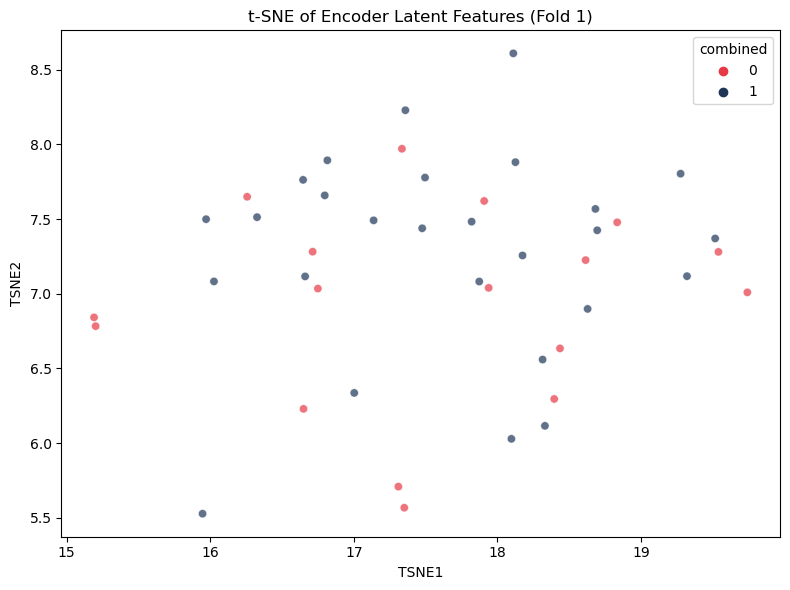

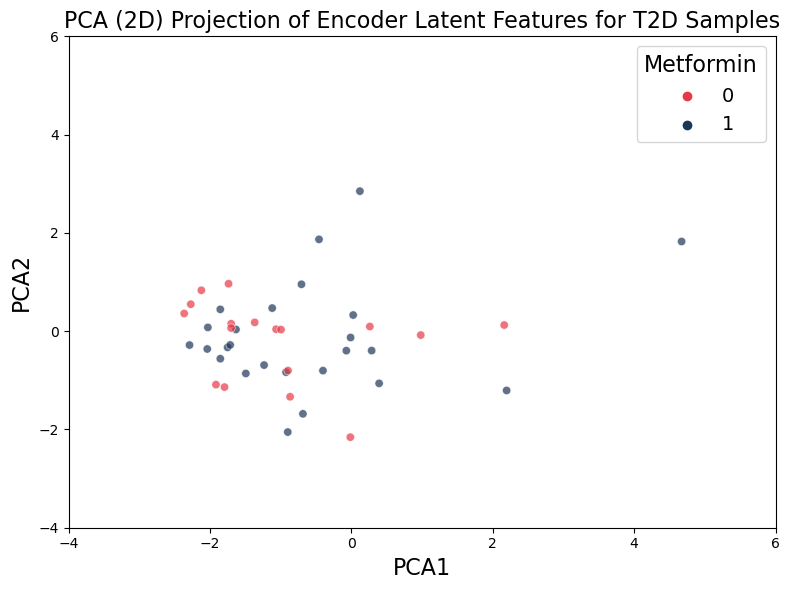

/home/mmonshiz/miniconda3/envs/confounder_free/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


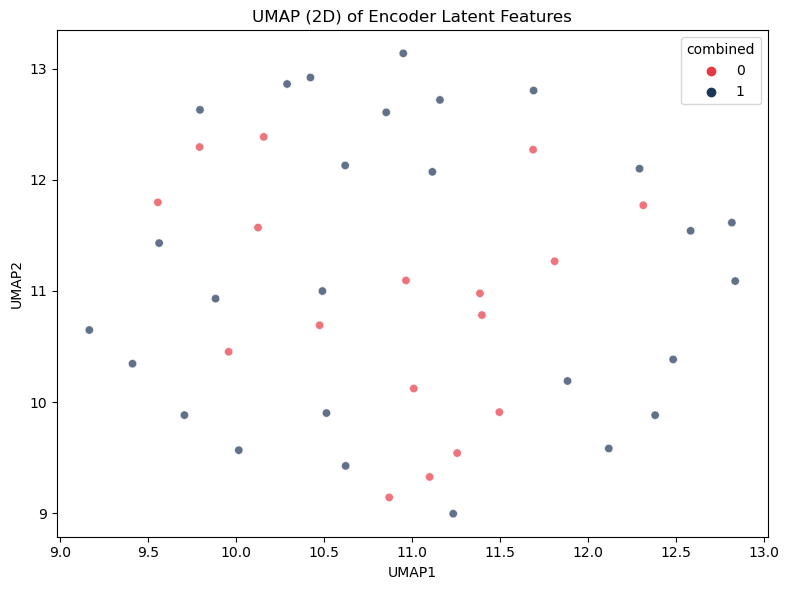

Silhouette Score: -0.08724010735750198
Davies-Bouldin Index: 2.6719110240072284
Cluster Separation: 0.8499046087540503
Within-Cluster Variance: 20.78404391895641


In [6]:
# encoder_features_tsne.ipynb

import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

# For dimensionality reduction and visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# For PCA
from sklearn.decomposition import PCA
# For UMAP (make sure you have 'umap-learn' package installed: pip install umap-learn)
import umap.umap_ as umap

# -- Import your custom modules (same as in main.py) --
from MicroKPNN_encoder_confounder_free_lib.data_utils import get_data
from MicroKPNN_encoder_confounder_free_lib.models import GAN
from MicroKPNN_encoder_confounder_free_lib.utils import create_stratified_dataloader

# ----------------------------
# 1. Load your data
# ----------------------------

# Adjust paths as needed
train_abundance_path = 'MetaCardis_data/new_train_T2D_abundance_with_taxon_ids.csv'
train_metadata_path  = 'MetaCardis_data/train_T2D_metadata.csv'

# If you want to do TSNE on test data instead, change accordingly
test_abundance_path  = 'MetaCardis_data/new_test_T2D_abundance_with_taxon_ids.csv'
test_metadata_path   = 'MetaCardis_data/test_T2D_metadata.csv'

# We'll load BOTH train and test sets, then optionally concatenate or pick one
df_train = get_data(train_abundance_path, train_metadata_path)
df_test  = get_data(test_abundance_path,  test_metadata_path)

# Let’s combine them if you want to do TSNE on the entire set. 
# Otherwise, you can pick just train or test
# df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all = df_test[df_test['PATGROUPFINAL_C']==1]

# ----------------------------
# 2. Create "combined" column
# ----------------------------
# combined = PATGROUPFINAL_C (0 or 1) + METFORMIN_C (0 or 1)
df_all['combined'] = df_all['PATGROUPFINAL_C'].astype(str) + df_all['METFORMIN_C'].astype(str)

# ----------------------------
# 3. Identify feature columns
# ----------------------------
# We do the same logic as in main.py to separate metadata from actual features
metadata_cols = pd.read_csv(train_metadata_path).columns.tolist()
metadata_cols += ['combined']
feature_columns = [
    col for col in df_all.columns if col not in metadata_cols and col != 'SampleID'
]

# Extract the feature matrix X and the combined column (for coloring)
X_all = df_all[feature_columns].values.astype(np.float32)
combined_labels = df_all['METFORMIN_C'].values  # Strings like "00", "01", "10", "11"

# Also store sample IDs if you want to track them
sample_ids = df_all['SampleID'].values

# ----------------------------
# 4. Define the same model structure used in main.py
#    and load each of the 5 fold models
# ----------------------------

# You need the same mask that was built in your main code for the MaskedLinear
# We'll replicate the process or load it if you saved it somewhere
# Suppose you saved the 'EdgeList.csv' and repeated the same steps:

edge_list_path = "Default_Database/EdgeList.csv"

relative_abundance_train = pd.read_csv(train_abundance_path, index_col=0)
species = relative_abundance_train.columns.values.tolist()

def build_mask(edge_list, species):
    edge_df = pd.read_csv(edge_list)
    edge_df['parent'] = edge_df['parent'].astype(str)
    parent_nodes = sorted(set(edge_df['parent'].tolist()))
    mask = torch.zeros(len(species), len(parent_nodes))
    child_nodes = species

    parent_dict = {k: i for i, k in enumerate(parent_nodes)}
    child_dict  = {k: i for i, k in enumerate(child_nodes)}

    for i, row in edge_df.iterrows():
        if row['child'] != 'Unnamed: 0': 
            mask[child_dict[str(row['child'])]][parent_dict[row['parent']]] = 1

    return mask.T, parent_dict

mask, _ = build_mask(edge_list_path, species)

# Model hyperparams (must match your main.py)
latent_dim = 64
num_layers = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We’ll collect the encoder’s outputs from each fold in a list
all_latent_features_per_fold = []

# Loop over 5 folds
for fold in range(1, 6):
    # Rebuild the same model architecture
    model = GAN(mask=mask, num_layers=num_layers, latent_dim=latent_dim).to(device)
    # Load trained weights
    model_path = f"old_Results/MicroKPNN_encoder_confounder_free_plots/trained_model{fold}.pth"
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}")
        continue

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # ----------------------------
    # 5. Get the encoder output for the entire data (df_all)
    # ----------------------------
    # Convert X_all to torch tensor, push to device
    X_tensor = torch.tensor(X_all, dtype=torch.float32).to(device)

    with torch.no_grad():
        encoded = model.encoder(X_tensor)
    # Move back to CPU numpy
    encoded_np = encoded.cpu().numpy()

    # Store the result for later TSNE or immediate TSNE
    all_latent_features_per_fold.append(encoded_np)

# Now you have a list of 5 arrays, each is n_samples x latent_dim
# Decide if you want to average them, or keep them separate.
# For demonstration, let's say we do TSNE on the *first fold only*,
# or you can concatenate them. Examples are below:

# Example A: TSNE on the first fold only
latent_fold1 = all_latent_features_per_fold[0]

# Example B (optional): Concatenate all folds and then do TSNE
# stacked_latent = np.concatenate(all_latent_features_per_fold, axis=0)
# But note that means you'd also replicate your labels for each fold, etc.

# ----------------------------
# 6. Perform TSNE
# ----------------------------
# Here we do TSNE on just 'latent_fold1' for demonstration
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(latent_fold1)

# ----------------------------
# 7. Visualize or Save
# ----------------------------
# Let’s create a DataFrame to store results
tsne_df = pd.DataFrame({
    'TSNE1': latent_2d[:, 0],
    'TSNE2': latent_2d[:, 1],
    'combined': combined_labels,
    'SampleID': sample_ids
})

# Save if you want
# tsne_df.to_csv("encoder_fold1_tsne.csv", index=False)

# Quick scatter plot by "combined"
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='combined',
    data=tsne_df,
    palette=custom_palette,  # or any palette you like
    alpha=0.7
)
plt.title("t-SNE of Encoder Latent Features (Fold 1)")
plt.legend(title='combined')
plt.tight_layout()
output_filename = "MicroKPNN_cf_tsne_encoder.png"
# plt.savefig(output_filename, dpi=300, format='png')
plt.show()

# -----------
# PCA
# -----------
custom_palette = {
    0: '#E63946',  # Red for class 0
    1: '#1D3557',  # Blue for class 1
}

pca = PCA(n_components=2, random_state=42)
pca_2d = pca.fit_transform(encoded_np)  # shape -> N x 2

# Create a small DataFrame to keep track of PCA coords + your label
pca_df = pd.DataFrame({
    'PCA1': pca_2d[:, 0],
    'PCA2': pca_2d[:, 1],
    'combined': combined_labels  # e.g. "00", "01", "10", "11"
})

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='combined', 
    data=pca_df, 
    palette=custom_palette, 
    alpha=0.7
)
plt.title("PCA (2D) Projection of Encoder Latent Features for T2D Samples", fontsize=16)
plt.xlabel("PCA1", fontsize=16)
plt.ylabel("PCA2", fontsize=16)
plt.legend(title='Metformin', fontsize=14, title_fontsize=16)
plt.xlim(-4, 6)  # Set x-axis limits
plt.ylim(-4, 6)
plt.tight_layout()
output_filename = "MicroKPNN_cf_PCA_encoder.pdf"
plt.savefig(output_filename, dpi=300, format='pdf')
plt.show()

# -----------
# U-map
# -----------

# UMAP can similarly reduce your N x latent_dim to N x 2.
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_2d = umap_reducer.fit_transform(encoded_np)  # shape -> N x 2

# Create DataFrame
umap_df = pd.DataFrame({
    'UMAP1': umap_2d[:, 0],
    'UMAP2': umap_2d[:, 1],
    'combined': combined_labels
})
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='UMAP1', y='UMAP2',
    hue='combined',
    data=umap_df,
    palette=custom_palette,
    alpha=0.7
)
plt.title("UMAP (2D) of Encoder Latent Features")
plt.legend(title='combined')
plt.tight_layout()
output_filename = "MicroKPNN_cf_Umap_encoder.pdf"
# plt.savefig(output_filename, dpi=300, format='pdf')
plt.show()


from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist

# Assume latent_2d is your reduced data and combined_labels are your labels
silhouette = silhouette_score(pca_2d, combined_labels)
print(f"Silhouette Score: {silhouette}")

db_index = davies_bouldin_score(pca_2d, combined_labels)
print(f"Davies-Bouldin Index: {db_index}")

# Calculate cluster centers
clusters = np.unique(combined_labels)
centers = [pca_2d[combined_labels == c].mean(axis=0) for c in clusters]
# Compute mean distance between cluster centers
cluster_separation = np.mean(cdist(centers, centers))
print(f"Cluster Separation: {cluster_separation}")

# Compute within-cluster variance
within_variance = sum(
    np.sum((pca_2d[combined_labels == c] - centers[i])**2) 
    for i, c in enumerate(clusters)
) / len(pca_2d)
print(f"Within-Cluster Variance: {within_variance}")


### FCNN_cf

/tmp/ipykernel_1219042/1394856939.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['combined'] = df_all['PATGROUPFINAL_C'].astype(str) + df_all['METFORMIN_C'].astype(str)
/tmp/ipykernel_1219042/1394856939.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer 

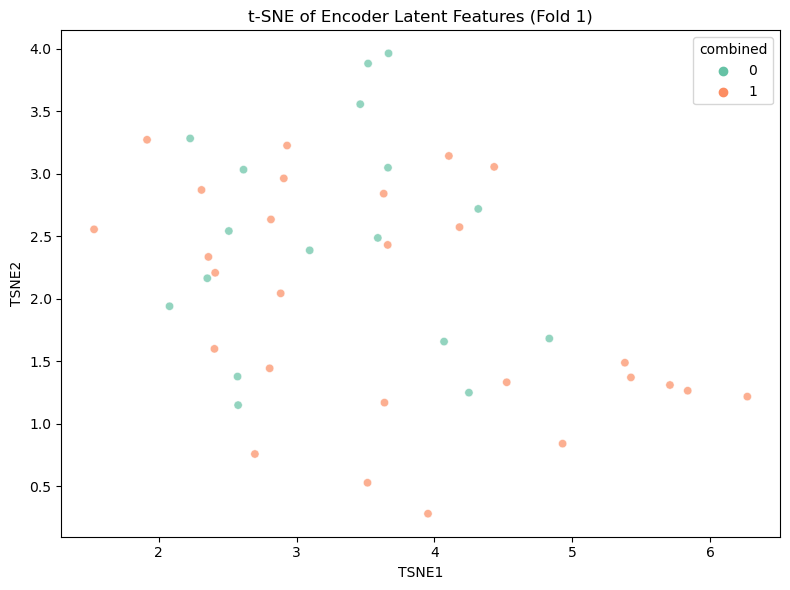

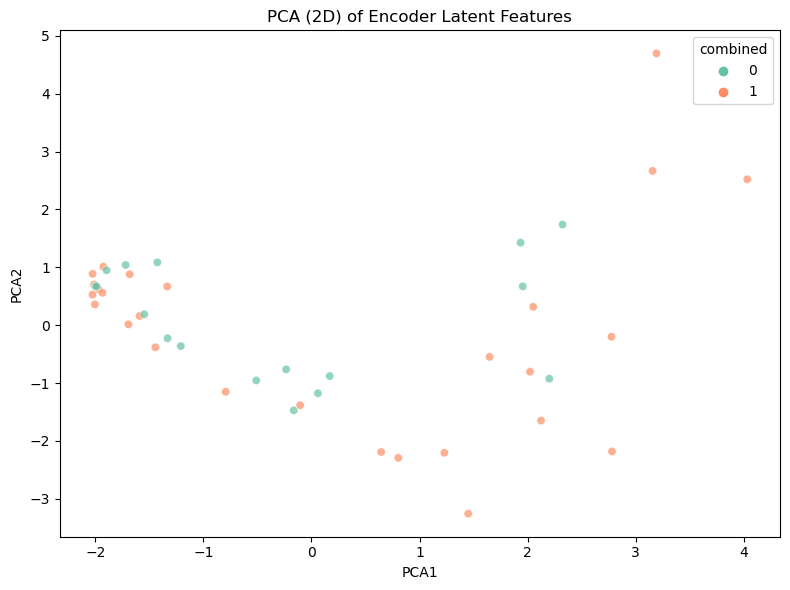

/home/mmonshiz/miniconda3/envs/confounder_free/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


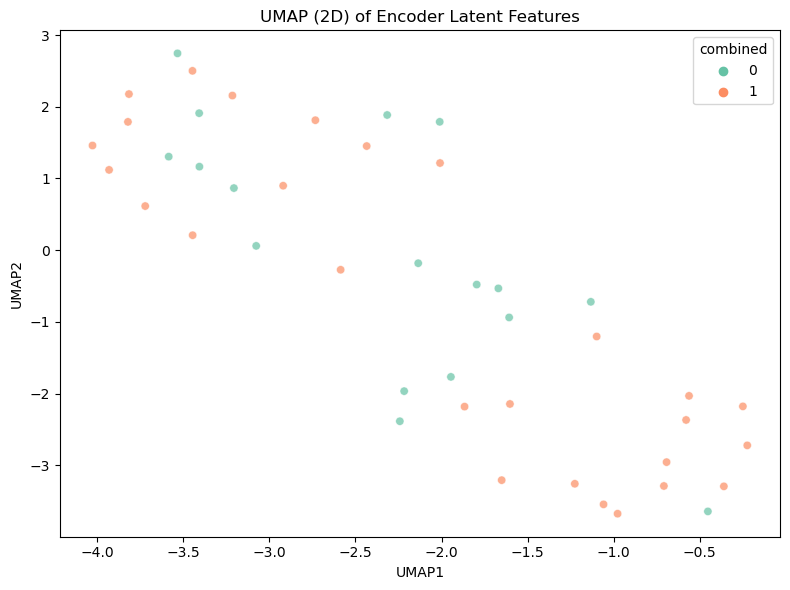

In [5]:
# encoder_features_tsne.ipynb

import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

# For dimensionality reduction and visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# For PCA
from sklearn.decomposition import PCA
# For UMAP (make sure you have 'umap-learn' package installed: pip install umap-learn)
import umap.umap_ as umap


# -- Import your custom modules (same as in main.py) --
from FCNN_lib.data_utils import get_data
from FCNN_lib.models import GAN
from FCNN_lib.utils import create_stratified_dataloader

# ----------------------------
# 1. Load your data
# ----------------------------

# Adjust paths as needed
train_abundance_path = 'MetaCardis_data/new_train_T2D_abundance_with_taxon_ids.csv'
train_metadata_path  = 'MetaCardis_data/train_T2D_metadata.csv'

# If you want to do TSNE on test data instead, change accordingly
test_abundance_path  = 'MetaCardis_data/new_test_T2D_abundance_with_taxon_ids.csv'
test_metadata_path   = 'MetaCardis_data/test_T2D_metadata.csv'

# We'll load BOTH train and test sets, then optionally concatenate or pick one
df_train = get_data(train_abundance_path, train_metadata_path)
df_test  = get_data(test_abundance_path,  test_metadata_path)

# Let’s combine them if you want to do TSNE on the entire set. 
# Otherwise, you can pick just train or test
# df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all = df_test[df_test['PATGROUPFINAL_C']==1]

# ----------------------------
# 2. Create "combined" column
# ----------------------------
# combined = PATGROUPFINAL_C (0 or 1) + METFORMIN_C (0 or 1)
df_all['combined'] = df_all['PATGROUPFINAL_C'].astype(str) + df_all['METFORMIN_C'].astype(str)

# ----------------------------
# 3. Identify feature columns
# ----------------------------
# We do the same logic as in main.py to separate metadata from actual features
metadata_cols = pd.read_csv(train_metadata_path).columns.tolist()
metadata_cols += ['combined']
feature_columns = [
    col for col in df_all.columns if col not in metadata_cols and col != 'SampleID'
]

# Extract the feature matrix X and the combined column (for coloring)
X_all = df_all[feature_columns].values.astype(np.float32)
combined_labels = df_all['METFORMIN_C'].values  # Strings like "00", "01", "10", "11"

# Also store sample IDs if you want to track them
sample_ids = df_all['SampleID'].values

# ----------------------------
# 4. Define the same model structure used in main.py
#    and load each of the 5 fold models
# ----------------------------

# You need the same mask that was built in your main code for the MaskedLinear
# We'll replicate the process or load it if you saved it somewhere
# Suppose you saved the 'EdgeList.csv' and repeated the same steps:



relative_abundance_train = pd.read_csv(train_abundance_path, index_col=0)
species = relative_abundance_train.columns.values.tolist()

# Model hyperparams (must match your main.py)
latent_dim = 64
num_layers = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We’ll collect the encoder’s outputs from each fold in a list
all_latent_features_per_fold = []

# Loop over 5 folds
for fold in range(1, 6):
    # Rebuild the same model architecture
    model = GAN(371, 64, 1).to(device)
    # Load trained weights
    model_path = f"Results/FCNN_encoder_confounder_free_plots/trained_model{fold}.pth"
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}")
        continue

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # ----------------------------
    # 5. Get the encoder output for the entire data (df_all)
    # ----------------------------
    # Convert X_all to torch tensor, push to device
    X_tensor = torch.tensor(X_all, dtype=torch.float32).to(device)

    with torch.no_grad():
        encoded = model.encoder(X_tensor)
    # Move back to CPU numpy
    encoded_np = encoded.cpu().numpy()

    # Store the result for later TSNE or immediate TSNE
    all_latent_features_per_fold.append(encoded_np)

# Now you have a list of 5 arrays, each is n_samples x latent_dim
# Decide if you want to average them, or keep them separate.
# For demonstration, let's say we do TSNE on the *first fold only*,
# or you can concatenate them. Examples are below:

# Example A: TSNE on the first fold only
latent_fold1 = all_latent_features_per_fold[0]

# Example B (optional): Concatenate all folds and then do TSNE
# stacked_latent = np.concatenate(all_latent_features_per_fold, axis=0)
# But note that means you'd also replicate your labels for each fold, etc.

# ----------------------------
# 6. Perform TSNE
# ----------------------------
# Here we do TSNE on just 'latent_fold1' for demonstration
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(latent_fold1)

# ----------------------------
# 7. Visualize or Save
# ----------------------------
# Let’s create a DataFrame to store results
tsne_df = pd.DataFrame({
    'TSNE1': latent_2d[:, 0],
    'TSNE2': latent_2d[:, 1],
    'combined': combined_labels,
    'SampleID': sample_ids
})

# Save if you want
tsne_df.to_csv("fcnn_encoder_fold1_tsne.csv", index=False)

# Quick scatter plot by "combined"
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='combined',
    data=tsne_df,
    palette='Set2',  # or any palette you like
    alpha=0.7
)
plt.title("t-SNE of Encoder Latent Features (Fold 1)")
plt.legend(title='combined')
plt.tight_layout()
output_filename = "FCNN_cf_tsne_encoder.png"
plt.savefig(output_filename, dpi=300, format='png')
plt.show()

# -----------
# PCA
# -----------

pca = PCA(n_components=2, random_state=42)
pca_2d = pca.fit_transform(encoded_np)  # shape -> N x 2

# Create a small DataFrame to keep track of PCA coords + your label
pca_df = pd.DataFrame({
    'PCA1': pca_2d[:, 0],
    'PCA2': pca_2d[:, 1],
    'combined': combined_labels  # e.g. "00", "01", "10", "11"
})

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='combined', 
    data=pca_df, 
    palette='Set2', 
    alpha=0.7
)
plt.title("PCA (2D) of Encoder Latent Features")
plt.legend(title='combined')
plt.tight_layout()
output_filename = "FCNN_cf_pca_encoder.png"
plt.savefig(output_filename, dpi=300, format='png')
plt.show()

# -----------
# U-map
# -----------

# UMAP can similarly reduce your N x latent_dim to N x 2.
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_2d = umap_reducer.fit_transform(encoded_np)  # shape -> N x 2

# Create DataFrame
umap_df = pd.DataFrame({
    'UMAP1': umap_2d[:, 0],
    'UMAP2': umap_2d[:, 1],
    'combined': combined_labels
})
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='UMAP1', y='UMAP2',
    hue='combined',
    data=umap_df,
    palette='Set2',
    alpha=0.7
)
plt.title("UMAP (2D) of Encoder Latent Features")
plt.legend(title='combined')
plt.tight_layout()
output_filename = "FCNN_cf_umap_encoder.png"
plt.savefig(output_filename, dpi=300, format='png')
plt.show()

